In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
fileName = "/content/casefile_v1_UTTAR_PRADESH_2023_24_UP_Secondary_Total_rural_merged.csv"

In [ ]:
try:
    df = pd.read_csv(fileName)
except FileNotFoundError:
    print(f"Error: File not found at {fileName}. Please ensure the path is correct.")

In [ ]:
indicator = "dropout_rate"
factors = [col for col in df.columns if col not in [indicator]]
num_samples, num_factors = df.shape[0], len(factors)

In [ ]:
corr = df.corr(method="pearson")

In [ ]:
THRESHOLD = 0.395
# THRESHOLD = 0.6

In [ ]:
G = nx.Graph()
G.add_nodes_from(factors, type="factor")
G.add_node(indicator, type="outcome")

In [ ]:
for i in factors:
    for j in factors:
        if i != j:
            r = corr.loc[i, j]
            if pd.notna(r) and abs(r) >= THRESHOLD:
                G.add_edge(i, j, weight=r)

for f in factors:
    r = corr.loc[f, indicator]
    if pd.notna(r) and abs(r) >= THRESHOLD:
        G.add_edge(f, indicator, weight=r)

# Functions, like sigmoid, forwards pass, etc.

In [ ]:
# look for inverse sigmoid
def sigmoid(x):
    mask = x >= 0
    positive_sig = 1 / (1 + np.exp(-x[mask]))
    negative_sig = np.exp(x[~mask]) / (np.exp(x[~mask]) + 1)

    result = np.empty_like(x)
    result[mask] = positive_sig
    result[~mask] = negative_sig
    return result

In [ ]:
def forward_pass(F, W, B):
    z = F @ W + B
    output = sigmoid(z)
    return output
    # return z

# def forward_pass(F, W, B):
#     n_samples, n_nodes = F.shape
#     F_new = np.zeros((n_samples, n_nodes))
#     for i in range(n_nodes): #19
#         col_sum = np.zeros(n_samples)
#         w_col = W[:, i]
#         for j in range(n_nodes):
#             col_sum += w_col[j] * F[:, j]
#         F_new[:, i] = col_sum + B[:, i]
#     return F_new

In [ ]:
def getError(F, F_hat):
    e = np.mean(F - F_hat, axis=0)
    return e

In [ ]:
def getError_mahalanobis_stable(F, F_hat, shrink_alpha=0.2, eps_std=1e-6, eps_cov=1e-6):

    mean = F.mean(axis=0)
    std = F.std(axis=0)
    std = np.maximum(std, eps_std)  # avoid divide by zero
    F_std = (F - mean) / std
    F_hat_std = (F_hat - mean) / std

    # --- Step 2: Covariance and shrinkage ---
    cov = np.cov(F_std, rowvar=False)
    diag_cov = np.diag(np.diag(cov))
    cov = (1 - shrink_alpha) * cov + shrink_alpha * diag_cov
    cov += np.eye(cov.shape[0]) * eps_cov  # extra regularization

    # --- Step 3: Pseudo-inverse (stable) ---
    inv_cov = np.linalg.pinv(cov)

    # --- Step 4: Weighted difference ---
    diff = F_hat_std - F_std  # (n_samples, n_features)
    weighted = diff @ inv_cov  # (n_samples, n_features)
    contrib = diff * weighted  # per-feature contribution (quadratic form parts)
    e = np.mean(contrib, axis=0)

    # --- Step 5: Optional normalization ---
    e = np.tanh(e)  # bound the values to [-1, 1] range
    return e

In [ ]:
def train_step(F, W, B, eta, MASK):
    F_hat = forward_pass(F, W, B)
    e = getError(F, F_hat)
    # e = getError_mahalanobis_stable(F, F_hat)
    F_avg = np.mean(F, axis=0)
    W = W + eta * e[np.newaxis, :] * F_avg
    W = W + eta * e[np.newaxis, :]
    np.fill_diagonal(W, 0)
    B = B + eta * e[np.newaxis, :]
    return W, B, F_hat, e

In [ ]:
def train_model(Factor_Data, W, B, MASK, eta=0.1, epochs=100):
    loss_history = []
    for epoch in range(1, epochs + 1):
        epoch_errors = []
        W, B, F_hat, e = train_step(Factor_Data, W, B, eta, MASK)
        MAE = np.mean(e)
        loss_history.append(MAE)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}/{epochs}: MAE Loss = {MAE:.6f}")
    return W, B, loss_history

In [ ]:
nodes = factors
A = nx.to_numpy_array(G, nodelist=nodes, weight='weight')
W = np.copy(A)

In [ ]:
W = W / (np.abs(W).max() + 1e-8)

W_initial = np.copy(W)
CONNECTION_MASK = (W_initial != 0).astype(int)
np.fill_diagonal(CONNECTION_MASK, 0)

B = np.full(num_factors, 0.02)
B = np.tile(B, (75, 1))
loss_history = []
Factor_Data = df[factors].values
Factor_Data = Factor_Data / Factor_Data.max(axis=0)

In [ ]:
n_samples, n_nodes = Factor_Data.shape
print(n_nodes)
print(n_samples)

19
75


In [ ]:
eta = 0.1
epochs = 100

$$z_i = \sum_{j} w_{ij}F_j + b_i$$

$$\hat{F}_i = \sigma(z_i) = 1/(1 + e^{-z_i})$$

$$e_i = F_i - \hat{F}_i$$

$$\text{Update: } w_{ij} += \eta e_i F_j, \quad b_i += \eta e_i$$

In [ ]:
W, B, loss_history = train_model(Factor_Data, W, B, CONNECTION_MASK, eta, epochs)

Epoch 001/100: MAE Loss = -0.122284
Epoch 010/100: MAE Loss = -0.014280
Epoch 020/100: MAE Loss = -0.001886
Epoch 030/100: MAE Loss = -0.000423
Epoch 040/100: MAE Loss = -0.000129
Epoch 050/100: MAE Loss = -0.000045
Epoch 060/100: MAE Loss = -0.000016
Epoch 070/100: MAE Loss = -0.000006
Epoch 080/100: MAE Loss = -0.000002
Epoch 090/100: MAE Loss = -0.000001
Epoch 100/100: MAE Loss = -0.000000


# So, I made graphs with taking both, F_avg as 1, and its original value. Overall, in both the cases, the error graph does reach zero, its just a question of when. In 1 case, it reaches zero in 100 epochs, in the other is ~150

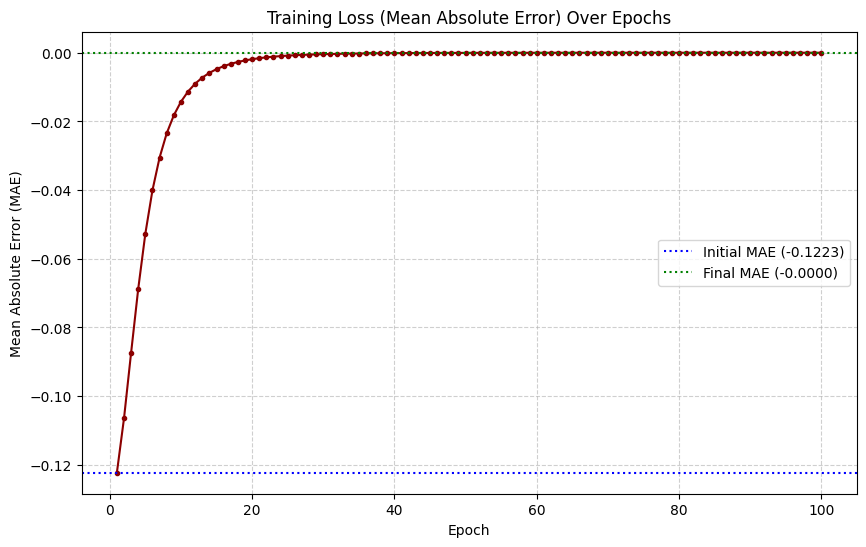

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='.', linestyle='-', color='darkred')
plt.title('Training Loss (Mean Absolute Error) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=loss_history[0], color='blue', linestyle=':', label=f'Initial MAE ({loss_history[0]:.4f})')
plt.axhline(y=loss_history[-1], color='green', linestyle=':', label=f'Final MAE ({loss_history[-1]:.4f})')
plt.legend()
plt.show()